In [6]:
format compact
addpath('./code')

In [2]:
testSequence = 'WHH';
% Valid choices are: 'WHH', 'MREV8', 'CORY48', 'CORY24', 
% 'YXX48', 'YXX24', 'YXX24S' (symmetrized YXX-24), 'AZ48'

## Coupling Strength Simulation

In [2]:
global Pulses dim
%% Initialize Test Variables

% Potential Test Vars
N = 4;
dim = 2^N ;
Ncyc = 1;

tau = 3e-6;
pulse = 1.5e-6;
Delta = 500;
coupling = 5000;

f1 = 1/4/pulse; %Can adjust f1 and w1 by changing 'pulse' variable
w1 = 2*pi*f1;

testVarCount = 40;

maxCoupling = 50000;
%maxCoupling = 5000;

maxTau = 10e-6;
maxDelta = 1000;

In [52]:
couplings = zeros(testVarCount);

for i=1:testVarCount
    couplings(i) = (i/testVarCount)*maxCoupling;
end


%% Generate Coupling Matrices

as = generateCoupling(N);


%% Setup Code Normally Run by spinSimNoPlots

% initialize Pauli matrices and transformation operators
z=0.5*sparse([1 0; 0 -1]);x=0.5*sparse( [ 0 1;1 0]); y=1i*0.5*sparse([0 -1;1 0]);
ep=sparse([1 0; 0 0]);
em=sparse([0 0; 0 1]);
id=speye(2);p=sparse([0 1;0 0]);m=sparse([0 0; 1 0]);


% collective spin observables
global X Y

Z=sparse(dim,dim);
X=sparse(dim,dim);
Y=sparse(dim,dim);

for k=1:N
      Z = Z + mykron(speye(2^(k-1)),z,speye(2^(N-k)));
      X = X + mykron(speye(2^(k-1)),x,speye(2^(N-k)));
      Y = Y + mykron(speye(2^(k-1)),y,speye(2^(N-k)));
end

raw_results = zeros(8,40);
raw_results_h2 = zeros(8,40);
results = zeros(40,1);
results_h2 = zeros(40,1);

%% Simulation

for dipVal=1:length(as)
    dip = as{dipVal};
    Hdip = getHdip(N, dim, x, y, z, dip);

    for testVal=1:length(couplings)
        coupling = couplings(testVal);

        %physical Hamiltonian
        Hint = Hdip*coupling + Z*Delta; 

        %experimental unitary operators
        Utau=(expm(-1i*Hint*2*pi*tau));
        UhalfTau = (expm(-1i*Hint*pi*tau));
        Ux = (expm(-1i*2*pi*(Hint+f1*X)*pulse));
        Uy = (expm(-1i*2*pi*(Hint+f1*Y)*pulse));
        Uxbar = (expm(-1i*2*pi*(Hint-f1*X)*pulse));
        Uybar = (expm(-1i*2*pi*(Hint-f1*Y)*pulse));
        
        % SIMULATE SPIN DYNAMICS - - - - - - - - - - - -

        % (Choose desired sequence to test)
        if strcmp(testSequence, 'WHH')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau;
            Havg = (Delta / 3) * (X + Y + Z); 
            testCyc = 12;
            cycleTime = 4 * pulse + 6 * tau;
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'MREV8')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uybar*Utau*Uxbar*Utau;
            Havg = (Delta / 3) * (X + Z) ;
            testCyc = 6;
            cycleTime = 8 * pulse + 12 * tau;
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'CORY48') % Not currently functional
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 72 * tau + 48 * pulse;

        elseif strcmp(testSequence, 'CORY24')
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;

        elseif strcmp(testSequence, 'YXX48')
            testUnitary = Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 48*tau + 48*pulse;

        elseif strcmp(testSequence, 'YXX24')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 24*tau + 24*pulse;

        elseif strcmp(testSequence, 'YXX24S')
            testUnitary = Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 48*tau + 48*pulse;

        elseif strcmp(testSequence, 'AZ48')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Ux*Utau*Uy*Utau*Uy*Utau*Uxbar;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 48*tau + 48*pulse;

        end
        
        
        
% CALCULATE AVERAGE HAMILTONIAN TERMS

        sequence = getSequence(testSequence);
        Pulses = sequence.Pulses;
        Taus = tau * sequence.Taus;
        tCyc = sum(Taus);
        
        toggledHsys = {};
        for p = 0:length(Pulses)
            toggledHsys{p+1} = getURF(p)'*Hint*getURF(p);
        end
        
        %Calculate 0th order Magnus term
        H0 = zeros(dim,dim);
        for k=0:length(Pulses)
            URF = getURF(k);
            Htilde = (URF')*Hint*URF;
            H0 = H0 + (Taus(k+1))*Htilde;
        end

        H0 = (1/tCyc)*H0;


        %Calculate 1st order Magnus term
        H1 = zeros(dim,dim);
        for k=1:length(Pulses)
            for j=0:k-1
                Hk = toggledHsys{k+1};
                Hj = toggledHsys{j+1};
                H1 = H1 + comm(Hk,Hj)*Taus(k+1)*Taus(j+1);
            end
        end

        H1 = (1/(2*1i*tCyc))*H1;

        %Calculate 2nd order Magnus term
        H2 = zeros(dim,dim);
        for l=0:length(Pulses)
            for k=0:l
                for j=0:k
                    Hl = toggledHsys{l+1};
                    Hk = toggledHsys{k+1};
                    Hj = toggledHsys{j+1};

                    Hterm = comm(Hl,comm(Hk,Hj))+comm(comm(Hl,Hk),Hj);
                    H2 = H2 + Hterm*Taus(l+1)*Taus(k+1)*Taus(j+1);
                end
            end
        end

        H2 = (-1/(6*tCyc))*H2;       
        
        Havg = H0 + H1 + H2;
        
        %U0 = expm(-1i*H0*2*pi*cycleTime);
        Uavg = expm(-1i*Havg*2*pi*cycleTime);
        

% SPIN SIMULATION - - - - - - - - -

        UcumExp = testUnitary;  % experimental
        UcumH0 = U0;            % target (H0 for spectroscopic, id for time-suspension)
        UcumHavg = Uavg;        % first 3 terms

        for cycleCount=1:Ncyc
            fidelity0 = zeros(Ncyc, 1);
            fidelity3 = zeros(Ncyc, 1);

            %Unitary Evolution

            simTime = 0;

            % fidelity metric for unitary operators
            fidelity0(cycleCount) = metric(UcumExp, UcumH0, N); %exp compared to order 0
            fidelity3(cycleCount) = metric(UcumExp, UcumHavg, N); %exp compared to orders 0-2
            
            UcumExp = UcumExp * testUnitary;
            UcumH0 = UcumH0 * U0;
            UcumHavg = UcumHavg * Uavg;
            
        end      
        
        raw_results(dipVal,testVal)=fidelity0(Ncyc);
        raw_results_h2(dipVal,testVal)=fidelity3(Ncyc);
        
    end
end

for d=1:testVarCount
    for aa=1:8
        results(d) = results(d)+(1/8)*raw_results(aa,d);
        results_h2(d) = results_h2(d)+(1/8)*raw_results_h2(aa,d);
    end
end
'done'

ans =
    'done'


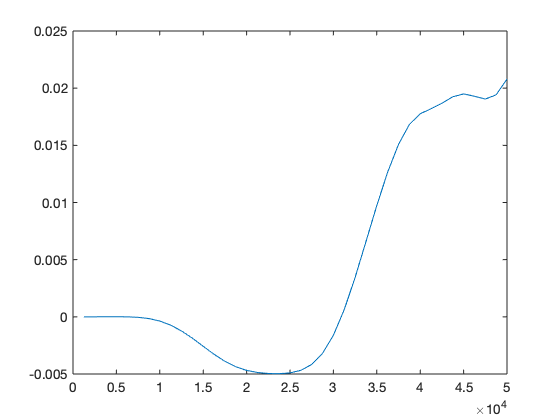

In [53]:
plot(couplings(:,1),results(:,1)-results_h2(:,1))

In [36]:
filename = strcat(testSequence,'_fidelity_coupling.mat')
%filename = strcat(testSequence,'_fidelity_coupling_lo.mat')

save(filename,'couplings','results','results_h2','Delta','tau')


filename =
    'WHH_fidelity_coupling.mat'


## Tau Simulation

In [69]:
testSequence = 'CORY48';
% Valid choices are: 'WHH', 'MREV8', 'CORY48', 'CORY24', 
% 'YXX48', 'YXX24', 'YXX24S' (symmetrized YXX-24), 'AZ48'

In [70]:
global Pulses dim
%% Initialize Test Variables

% Potential Test Vars
N = 4;
dim = 2^N ;
Ncyc = 1;

tau = 3e-6;
pulse = 1.5e-6;
Delta = 0;
coupling = 5000;

testVarCount = 40;
maxTau = 10e-6;


In [71]:
taus = zeros(testVarCount);

for i=1:testVarCount
    taus(i) = (i/testVarCount)*maxTau;
end


%% Generate Coupling Matrices

as = generateCoupling(N);


%% Setup Code Normally Run by spinSimNoPlots

% initialize Pauli matrices and transformation operators
z=0.5*sparse([1 0; 0 -1]);x=0.5*sparse( [ 0 1;1 0]); y=1i*0.5*sparse([0 -1;1 0]);
ep=sparse([1 0; 0 0]);
em=sparse([0 0; 0 1]);
id=speye(2);p=sparse([0 1;0 0]);m=sparse([0 0; 1 0]);


% collective spin observables
global X Y

Z=sparse(dim,dim);
X=sparse(dim,dim);
Y=sparse(dim,dim);

for k=1:N
      Z = Z + mykron(speye(2^(k-1)),z,speye(2^(N-k)));
      X = X + mykron(speye(2^(k-1)),x,speye(2^(N-k)));
      Y = Y + mykron(speye(2^(k-1)),y,speye(2^(N-k)));
end

raw_results = zeros(8,40);
raw_results_h2 = zeros(8,40);
results = zeros(40,1);
results_h2 = zeros(40,1);

%% Simulation

for dipVal=1:length(as)
    dip = as{dipVal};
    for testVal=1:length(taus)
        tau = taus(testVal);
        Tcyc = 6*tau + 4*pulse; % cycle time

        f1 = 1/4/pulse; %Can adjust f1 and w1 by changing 'pulse' variable
        w1 = 2*pi*f1;

        % define system observables and Hamiltonians

        Hdip = getHdip(N, dim, x, y, z, dip);

        %physical Hamiltonian
        Hint = Hdip*coupling + Z*Delta; 

        %Lowest order WAHUHA and MREV hamiltonian
        tc = 6*tau + 4*pulse;

        tcM = 12*tau + 8*pulse;

        % Define Unitaries

        %experimental unitary operators
        Utau=(expm(-1i*Hint*2*pi*tau));
        UhalfTau = (expm(-1i*Hint*pi*tau));
        Ux = (expm(-1i*2*pi*(Hint+f1*X)*pulse));
        Uy = (expm(-1i*2*pi*(Hint+f1*Y)*pulse));
        Uxbar = (expm(-1i*2*pi*(Hint-f1*X)*pulse));
        Uybar = (expm(-1i*2*pi*(Hint-f1*Y)*pulse));
        

        % SIMULATE SPIN DYNAMICS - - - - - - - - - - - -

        % (Choose desired sequence to test)
        if strcmp(testSequence, 'WHH')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau;
            deltaUnitary = Utau*UDxbar*Utau*UDy*Utau*Utau*UDybar*Utau*UDx*Utau;
            Havg = (Delta / 3) * (X + Y + Z); 
            testCyc = 12;
            
            cycleTime = 4 * pulse + 6 * tau;
            deltaCycleTime = 6 * tau;
            
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'MREV8')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uybar*Utau*Uxbar*Utau;
            Havg = (Delta / 3) * (X + Z) ;
            testCyc = 6;
            cycleTime = 8 * pulse + 12 * tau;
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'CORY48') % Not currently functional
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 72 * tau + 48 * pulse;

        elseif strcmp(testSequence, 'CORY24')
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;

        elseif strcmp(testSequence, 'YXX48')
            testUnitary = Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 49*tau + 48*pulse;

        elseif strcmp(testSequence, 'YXX24')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 25*tau + 24*pulse;

        elseif strcmp(testSequence, 'YXX24S')
            testUnitary = Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 49*tau + 48*pulse;

        elseif strcmp(testSequence, 'AZ48')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Ux*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 49*tau + 48*pulse;

        end
        
        
        
% CALCULATE AVERAGE HAMILTONIAN TERMS

        sequence = getSequence(testSequence);
        Pulses = sequence.Pulses;
        Taus = tau * sequence.Taus;
        tCyc = sum(Taus);
        
        toggledHsys = {};
        for p = 0:length(Pulses)
            toggledHsys{p+1} = getURF(p)'*Hint*getURF(p);
        end
        
        %Calculate 0th order Magnus term
        H0 = zeros(dim,dim);
        for k=0:length(Pulses)
            URF = getURF(k);
            Htilde = (URF')*Hint*URF;
            Taus(k+1);
            H0 = H0 + (Taus(k+1))*Htilde;
        end

        H0 = (1/tCyc)*H0;


        %Calculate 1st order Magnus term
        H1 = zeros(dim,dim);
        for k=1:length(Pulses)
            for j=0:k-1
                Hk = toggledHsys{k+1};
                Hj = toggledHsys{j+1};
                H1 = H1 + comm(Hk,Hj)*Taus(k+1)*Taus(j+1);
            end
        end

        H1 = (1/(2*1i*tCyc))*H1;

        %Calculate 2nd order Magnus term
        H2 = zeros(dim,dim);
        for l=0:length(Pulses)
            for k=0:l
                for j=0:k
                    Hl = toggledHsys{l+1};
                    Hk = toggledHsys{k+1};
                    Hj = toggledHsys{j+1};

                    Hterm = comm(Hl,comm(Hk,Hj))+comm(comm(Hl,Hk),Hj);
                    H2 = H2 + Hterm*Taus(l+1)*Taus(k+1)*Taus(j+1);
                end
            end
        end

        H2 = (-1/(6*tCyc))*H2;       
        
        Havg = H0 + H1 + H2;
        
        Uavg = expm(-1i*Havg*2*pi*cycleTime);
        

% SPIN SIMULATION - - - - - - - - -

        UcumExp = testUnitary;  % experimental
        UcumD = deltaUnitary;    %infinitesimal (delta) pulses
        
        UcumH0 = U0;            % target (H0 for spectroscopic, id for time-suspension)
        UcumHavg = Uavg;        % first 3 terms

        for cycleCount=1:Ncyc
            fidelity0 = zeros(Ncyc, 1);
            fidelity3 = zeros(Ncyc, 1);
            fidelityD = zeros(Ncyc, 1);

            %Unitary Evolution

            simTime = 0;

            % fidelity metric for unitary operators
            fidelity0(cycleCount) = metric(UcumExp, UcumH0, N); %exp compared to order 0
            fidelity3(cycleCount) = metric(UcumExp, UcumHavg, N); %exp compared to orders 0-2
            
            fidelityD(cycleCount) = metric(UcumD, UcumH0, N); %deltapulse compared to order 0
            
            UcumExp = UcumExp * testUnitary;
            UcumH0 = UcumH0 * U0;
            UcumHavg = UcumHavg * Uavg;
            UcumD = UcumD * deltaUnitary;
            
        end      
        
        raw_results(dipVal,testVal)=fidelity0(Ncyc);
        %raw_results_h2(dipVal,testVal)=fidelity3(Ncyc);
        raw_results_h2(dipVal,testVal) = fidelityD(Ncyc);
        
    end
end

for d=1:40
    for aa=1:8
        results(d) = results(d)+(1/8)*raw_results(aa,d);
        results_h2(d) = results_h2(d)+(1/8)*raw_results_h2(aa,d);
    end
end
'done'

Operation terminated by user during expm>pade_approx (line 120)

In expm (line 76)
F = pade_approx(T, Tpowers, m);
In getURF (line 19)
            URF = expm(-1i*Pulses{j}*pi/2) * URF;


the MATLAB function has been cancelled


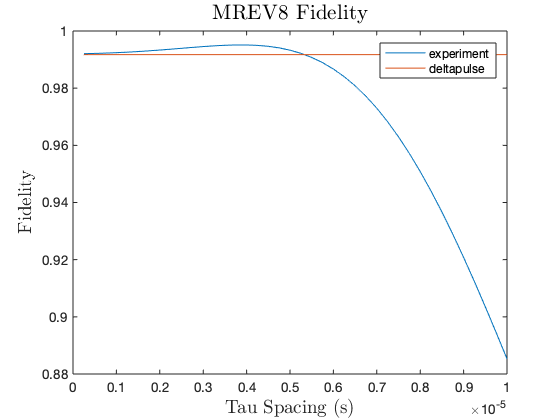

In [67]:
plot(taus(:,1),results(:,1))
hold on
plot(taus(:,1),results_h2(:,1))

h=title(strcat(testSequence,' Fidelity'));
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);
legend('experiment','deltapulse')

In [68]:
filename = strcat(testSequence,'_fidelity_tau_deltapulse.mat')
save(filename,'taus','results','results_h2','Delta','coupling')

filename =
    'MREV8_fidelity_tau_deltapulse.mat'


# $\Delta$ Simulation

In [16]:
global Pulses dim
%% Initialize Test Variables

% Potential Test Vars
N = 4;
dim = 2^N ;
Ncyc = 1;

tau = 3e-6;
pulse = 1.5e-6;
Delta = 0;
coupling = 5000;

testVarCount = 40;

maxCoupling = 50000;
%maxCoupling = 5000;

maxTau = 10e-6;
maxDelta = 1000;

In [17]:
deltas = zeros(testVarCount);

for i=1:testVarCount
    deltas(i) = 2*(i-(testVarCount/2))*(maxDelta/testVarCount);

end


%% Generate Coupling Matrices

as = generateCoupling(N);


%% Setup Code Normally Run by spinSimNoPlots

% initialize Pauli matrices and transformation operators
z=0.5*sparse([1 0; 0 -1]);x=0.5*sparse( [ 0 1;1 0]); y=1i*0.5*sparse([0 -1;1 0]);
ep=sparse([1 0; 0 0]);
em=sparse([0 0; 0 1]);
id=speye(2);p=sparse([0 1;0 0]);m=sparse([0 0; 1 0]);


% collective spin observables
global X Y

Z=sparse(dim,dim);
X=sparse(dim,dim);
Y=sparse(dim,dim);

for k=1:N
      Z = Z + mykron(speye(2^(k-1)),z,speye(2^(N-k)));
      X = X + mykron(speye(2^(k-1)),x,speye(2^(N-k)));
      Y = Y + mykron(speye(2^(k-1)),y,speye(2^(N-k)));
end

raw_results = zeros(8,40);
raw_results_h2 = zeros(8,40);
results = zeros(40,1);
results_h2 = zeros(40,1);

%% Simulation

for dipVal=1:length(as)
    dip = as{dipVal};
    for testVal=1:length(deltas)
        Delta = deltas(testVal);
        Tcyc = 6*tau + 4*pulse; % cycle time

        f1 = 1/4/pulse; %Can adjust f1 and w1 by changing 'pulse' variable
        w1 = 2*pi*f1;

        % define system observables and Hamiltonians

        Hdip = getHdip(N, dim, x, y, z, dip);

        %physical Hamiltonian
        Hint = Hdip*coupling + Z*Delta; 

        %Lowest order WAHUHA and MREV hamiltonian
        tc = 6*tau + 4*pulse;

        tcM = 12*tau + 8*pulse;

        % Define Unitaries

        %experimental unitary operators
        Utau=(expm(-1i*Hint*2*pi*tau));
        UhalfTau = (expm(-1i*Hint*pi*tau));
        Ux = (expm(-1i*2*pi*(Hint+f1*X)*pulse));
        Uy = (expm(-1i*2*pi*(Hint+f1*Y)*pulse));
        Uxbar = (expm(-1i*2*pi*(Hint-f1*X)*pulse));
        Uybar = (expm(-1i*2*pi*(Hint-f1*Y)*pulse));

        % SIMULATE SPIN DYNAMICS - - - - - - - - - - - -

        % (Choose desired sequence to test)
        if strcmp(testSequence, 'WHH')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau;
            Havg = (Delta / 3) * (X + Y + Z); 
            testCyc = 12;
            cycleTime = 4 * pulse + 6 * tau;
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'MREV8')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uybar*Utau*Uxbar*Utau;
            Havg = (Delta / 3) * (X + Z) ;
            testCyc = 6;
            cycleTime = 8 * pulse + 12 * tau;
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'CORY48') % Not currently functional
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 72 * tau + 48 * pulse;

        elseif strcmp(testSequence, 'CORY24')
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;

        elseif strcmp(testSequence, 'YXX48')
            testUnitary = Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 49*tau + 48*pulse;

        elseif strcmp(testSequence, 'YXX24')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 25*tau + 24*pulse;

        elseif strcmp(testSequence, 'YXX24S')
            testUnitary = Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 49*tau + 48*pulse;

        elseif strcmp(testSequence, 'AZ48')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Ux*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 49*tau + 48*pulse;

        end
        
        
        
% CALCULATE AVERAGE HAMILTONIAN TERMS

        sequence = getSequence(testSequence);
        Pulses = sequence.Pulses;
        Taus = tau * sequence.Taus;
        tCyc = sum(Taus);
        
        toggledHsys = {};
        for p = 0:length(Pulses)
            toggledHsys{p+1} = getURF(p)'*Hint*getURF(p);
        end
        
        %Calculate 0th order Magnus term
        H0 = zeros(dim,dim);
        for k=0:length(Pulses)
            URF = getURF(k);
            Htilde = (URF')*Hint*URF;
            Taus(k+1);
            H0 = H0 + (Taus(k+1))*Htilde;
        end

        H0 = (1/tCyc)*H0;


        %Calculate 1st order Magnus term
        H1 = zeros(dim,dim);
        for k=1:length(Pulses)
            for j=0:k-1
                Hk = toggledHsys{k+1};
                Hj = toggledHsys{j+1};
                H1 = H1 + comm(Hk,Hj)*Taus(k+1)*Taus(j+1);
            end
        end

        H1 = (1/(2*1i*tCyc))*H1;

        %Calculate 2nd order Magnus term
        H2 = zeros(dim,dim);
        for l=0:length(Pulses)
            for k=0:l
                for j=0:k
                    Hl = toggledHsys{l+1};
                    Hk = toggledHsys{k+1};
                    Hj = toggledHsys{j+1};

                    Hterm = comm(Hl,comm(Hk,Hj))+comm(comm(Hl,Hk),Hj);
                    H2 = H2 + Hterm*Taus(l+1)*Taus(k+1)*Taus(j+1);
                end
            end
        end

        H2 = (-1/(6*tCyc))*H2;       
        
        Havg = H0 + H1 + H2;
        
        Uavg = expm(-1i*Havg*2*pi*cycleTime);
        

% SPIN SIMULATION - - - - - - - - -

        UcumExp = testUnitary;  % experimental
        UcumH0 = U0;            % target (H0 for spectroscopic, id for time-suspension)
        UcumHavg = Uavg;        % first 3 terms

        for cycleCount=1:Ncyc
            fidelity0 = zeros(Ncyc, 1);
            fidelity3 = zeros(Ncyc, 1);

            %Unitary Evolution

            simTime = 0;

            % fidelity metric for unitary operators
            fidelity0(cycleCount) = metric(UcumExp, UcumH0, N); %exp compared to order 0
            fidelity3(cycleCount) = metric(UcumExp, UcumHavg, N); %exp compared to orders 0-2
            
            UcumExp = UcumExp * testUnitary;
            UcumH0 = UcumH0 * U0;
            UcumHavg = UcumHavg * Uavg;
            
        end      
        
        raw_results(dipVal,testVal)=fidelity0(Ncyc);
        raw_results_h2(dipVal,testVal)=fidelity3(Ncyc);
        
    end
end

for d=1:40
    for aa=1:8
        results(d) = results(d)+(1/8)*raw_results(aa,d);
        results_h2(d) = results_h2(d)+(1/8)*raw_results_h2(aa,d);
    end
end
'done'

ans =
    'done'


In [18]:
filename = strcat(testSequence,'_fidelity_Delta.mat')
save(filename,'deltas','results','results_h2','coupling','tau')

filename =
    'CORY48_fidelity_Delta.mat'


# Tau Simulation: DeltaPulse vs Experimental Pulse (no magnus)

In [10]:
testSequence = 'AZ48';
% Valid choices are: 'WHH', 'MREV8', 'CORY48', 'CORY24', 
% 'YXX48', 'YXX24', 'YXX24S' (symmetrized YXX-24), 'AZ48'

In [11]:
global Pulses dim
%% Initialize Test Variables

% Potential Test Vars
N = 4;
dim = 2^N ;
Ncyc = 1;

tau = 3e-6;
pulse = 1.5e-6;
Delta = 0;
coupling = 5000;

testVarCount = 40;

maxCoupling = 50000;
%maxCoupling = 5000;

maxTau = 10e-6;
maxDelta = 1000;

In [12]:
taus = zeros(testVarCount);

for i=1:testVarCount
    taus(i) = (i/testVarCount)*maxTau;
end


%% Generate Coupling Matrices

as = generateCoupling(N);


%% Setup Code Normally Run by spinSimNoPlots

% initialize Pauli matrices and transformation operators
z=0.5*sparse([1 0; 0 -1]);x=0.5*sparse( [ 0 1;1 0]); y=1i*0.5*sparse([0 -1;1 0]);
ep=sparse([1 0; 0 0]);
em=sparse([0 0; 0 1]);
id=speye(2);p=sparse([0 1;0 0]);m=sparse([0 0; 1 0]);


% collective spin observables
global X Y

Z=sparse(dim,dim);
X=sparse(dim,dim);
Y=sparse(dim,dim);

for k=1:N
      Z = Z + mykron(speye(2^(k-1)),z,speye(2^(N-k)));
      X = X + mykron(speye(2^(k-1)),x,speye(2^(N-k)));
      Y = Y + mykron(speye(2^(k-1)),y,speye(2^(N-k)));
end

raw_results = zeros(8,40);
raw_results_h2 = zeros(8,40);
results = zeros(40,1);
results_h2 = zeros(40,1);

%% Simulation

for dipVal=1:length(as)
    dip = as{dipVal};
    for testVal=1:length(taus)
        tau = taus(testVal);
        Tcyc = 6*tau + 4*pulse; % cycle time

        f1 = 1/4/pulse; %Can adjust f1 and w1 by changing 'pulse' variable
        w1 = 2*pi*f1;

        % define system observables and Hamiltonians

        Hdip = getHdip(N, dim, x, y, z, dip);

        %physical Hamiltonian
        Hint = Hdip*coupling + Z*Delta; 

        %Lowest order WAHUHA and MREV hamiltonian
        tc = 6*tau + 4*pulse;

        tcM = 12*tau + 8*pulse;

        % Define Unitaries

        %experimental unitary operators
        Utau= expm(-1i*Hint*2*pi*tau);
        UhalfTau = expm(-1i*Hint*pi*tau);
        Ux = expm(-1i*2*pi*(Hint+f1*X)*pulse);
        Uy = expm(-1i*2*pi*(Hint+f1*Y)*pulse);
        Uxbar = expm(-1i*2*pi*(Hint-f1*X)*pulse);
        Uybar = expm(-1i*2*pi*(Hint-f1*Y)*pulse);
        
        %delta pulse unitary operators
        UDx = expm(-1i*Hint*2*pi*pulse/2)*expm(-1i*pi*X/2)*expm(-1i*Hint*2*pi*pulse/2);
        UDy = expm(-1i*Hint*2*pi*pulse/2)*expm(-1i*pi*Y/2)*expm(-1i*Hint*2*pi*pulse/2);
        UDxbar = expm(-1i*Hint*2*pi*pulse/2)*expm(-1i*pi*(-X/2))*expm(-1i*Hint*2*pi*pulse/2);
        UDybar = expm(-1i*Hint*2*pi*pulse/2)*expm(-1i*pi*(-Y/2))*expm(-1i*Hint*2*pi*pulse/2);

        % SIMULATE SPIN DYNAMICS - - - - - - - - - - - -

        % (Choose desired sequence to test)
        if strcmp(testSequence, 'WHH')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau;
            deltaUnitary = Utau*UDxbar*Utau*UDy*Utau*Utau*UDybar*Utau*UDx*Utau;
            Havg = (Delta / 3) * (X + Y + Z); 
            testCyc = 12;
            
            cycleTime = 4 * pulse + 6 * tau;
            
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'MREV8')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uybar*Utau*Uxbar*Utau;
            deltaUnitary = Utau*UDxbar*Utau*UDy*Utau*Utau*UDybar*Utau*UDx*Utau*Utau*UDx*Utau*UDy*Utau*Utau*UDybar*Utau*UDxbar*Utau;
            Havg = (Delta / 3) * (X + Z) ;
            testCyc = 6;
            cycleTime = 8 * pulse + 12 * tau;
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'CORY48') % Not currently functional
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;
            deltaUnitary = Utau*UDx*Utau*UDybar*Utau*Utau*UDx*Utau*UDy*Utau*Utau*UDx*Utau*UDybar*Utau*Utau*UDxbar*Utau*UDy*Utau*Utau*UDx*Utau*UDy*Utau*Utau*UDxbar*Utau*UDy*Utau*Utau*UDybar*Utau*UDx*Utau*Utau*UDybar*Utau*UDxbar*Utau*Utau*UDybar*Utau*UDx*Utau*Utau*UDy*Utau*UDxbar*Utau*Utau*UDybar*Utau*UDxbar*Utau*Utau*UDy*Utau*UDxbar*Utau*Utau*UDxbar*Utau*UDybar*Utau*Utau*UDx*Utau*UDybar*Utau*Utau*UDxbar*Utau*UDybar*Utau*Utau*UDxbar*Utau*UDybar*Utau*Utau*UDxbar*Utau*UDy*Utau*Utau*UDxbar*Utau*UDybar*Utau*Utau*UDy*Utau*UDx*Utau*Utau*UDybar*Utau*UDx*Utau*Utau*UDy*Utau*UDx*Utau*Utau*UDy*Utau*UDx*Utau*Utau*UDy*Utau*UDxbar*Utau*Utau*UDy*Utau*UDx*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 72 * tau + 48 * pulse;

        elseif strcmp(testSequence, 'CORY24')
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;

        elseif strcmp(testSequence, 'YXX48')
            testUnitary = Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy;
            deltaUnitary = Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDxbar*Utau*UDxbar*Utau*UDy*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDxbar*Utau*UDxbar*Utau*UDy*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDxbar*Utau*UDxbar*Utau*UDy*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDxbar*Utau*UDxbar*Utau*UDy*Utau*UDxbar*Utau*UDxbar*Utau*UDy*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDxbar*Utau*UDxbar*Utau*UDy*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDxbar*Utau*UDxbar*Utau*UDy*Utau*UDxbar*Utau*UDxbar*Utau*UDy;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 48*tau + 48*pulse;

        elseif strcmp(testSequence, 'YXX24')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau;
            deltaUnitary = Utau*UDxbar*Utau*UDxbar*Utau*UDy*Utau*UDxbar*Utau*UDx*Utau*UDybar*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDx*Utau*UDxbar*Utau*UDy*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDx*Utau*UDxbar*Utau*UDy*Utau*UDxbar*Utau*UDxbar*Utau*UDy*Utau*UDxbar*Utau*UDx*Utau*UDybar*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 24*tau + 24*pulse;

        elseif strcmp(testSequence, 'YXX24S')
            testUnitary = Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 48*tau + 48*pulse;

        elseif strcmp(testSequence, 'AZ48')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Ux*Utau*Uy*Utau*Uy*Utau*Uxbar;
            deltaUnitary = Utau*UDxbar*Utau*UDxbar*Utau*UDybar*Utau*UDxbar*Utau*UDxbar*Utau*UDybar*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDx*Utau*UDybar*Utau*UDybar*Utau*UDx*Utau*UDybar*Utau*UDy*Utau*UDy*Utau*UDxbar*Utau*UDy*Utau*UDy*Utau*UDxbar*Utau*UDxbar*Utau*UDybar*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDx*Utau*UDybar*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDx*Utau*UDx*Utau*UDy*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDy*Utau*UDy*Utau*UDx*Utau*UDy*Utau*UDy*Utau*UDxbar;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 48*tau + 48*pulse;

        end
        
        
        

        

% SPIN SIMULATION - - - - - - - - -

        UcumExp = testUnitary;  % experimental
        UcumD = deltaUnitary;    %infinitesimal (delta) pulses
        
        UcumH0 = U0;            % target (H0 for spectroscopic, id for time-suspension)

        for cycleCount=1:Ncyc
            fidelity0 = zeros(Ncyc, 1);
            fidelity3 = zeros(Ncyc, 1);
            fidelityD = zeros(Ncyc, 1);

            %Unitary Evolution

            simTime = 0;

            % fidelity metric for unitary operators
            fidelity0(cycleCount) = metric(UcumExp, UcumH0, N); %exp compared to order 0
            
            fidelityD(cycleCount) = metric(UcumD, UcumH0, N); %deltapulse compared to order 0
            
            UcumExp = UcumExp * testUnitary;
            UcumH0 = UcumH0 * U0;
            UcumD = UcumD * deltaUnitary;
            
        end      
        
        raw_results(dipVal,testVal)=fidelity0(Ncyc);
        raw_results_h2(dipVal,testVal) = fidelityD(Ncyc);
        
    end
end

for d=1:40
    for aa=1:8
        results(d) = results(d)+(1/8)*raw_results(aa,d);
        results_h2(d) = results_h2(d)+(1/8)*raw_results_h2(aa,d);
    end
end
'done'

ans =
    'done'


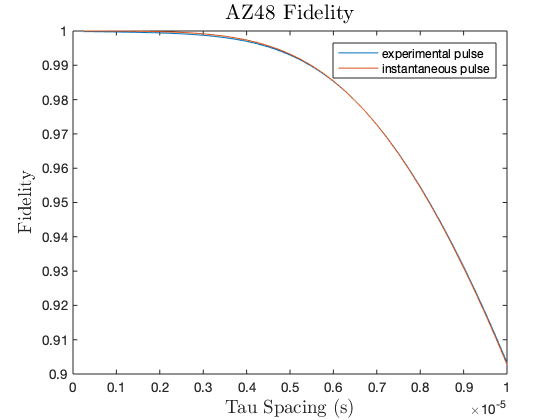

In [13]:
plot(taus(:,1),results(:,1))
hold on
plot(taus(:,1),results_h2(:,1))

h=title(strcat(testSequence,' Fidelity'));
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);
legend('experimental pulse','instantaneous pulse')

In [14]:
filename = strcat(testSequence,'_fidelity_tau_deltapulse.mat')
save(filename,'taus','results','results_h2','Delta','coupling')

filename =
    'AZ48_fidelity_tau_deltapulse.mat'


# Both Error Types (Delta Pulse AND Magnus 0-2)

Runs all four combinations of experimental and theoretical unitary:

In [33]:
testSequence = 'CORY48';
% Valid choices are: 'WHH', 'MREV8', 'CORY48', 'CORY24', 
% 'YXX48', 'YXX24', 'YXX24S' (symmetrized YXX-24), 'AZ48'

In [34]:
global Pulses dim
%% Initialize Test Variables

% Potential Test Vars
N = 4;
dim = 2^N ;
Ncyc = 1;

tau = 3e-6;
pulse = 1.5e-6;
Delta = 500;
coupling = 5000;

testVarCount = 40;

maxCoupling = 50000;
%maxCoupling = 5000;

maxTau = 10e-6;
maxDelta = 1000;

In [35]:
taus = zeros(testVarCount);

for i=1:testVarCount
    taus(i) = (i/testVarCount)*maxTau;
end


%% Generate Coupling Matrices

as = generateCoupling(N);


%% Setup Code Normally Run by spinSimNoPlots

% initialize Pauli matrices and transformation operators
z=0.5*sparse([1 0; 0 -1]);x=0.5*sparse( [ 0 1;1 0]); y=1i*0.5*sparse([0 -1;1 0]);
ep=sparse([1 0; 0 0]);
em=sparse([0 0; 0 1]);
id=speye(2);p=sparse([0 1;0 0]);m=sparse([0 0; 1 0]);


% collective spin observables
global X Y

Z=sparse(dim,dim);
X=sparse(dim,dim);
Y=sparse(dim,dim);

for k=1:N
      Z = Z + mykron(speye(2^(k-1)),z,speye(2^(N-k)));
      X = X + mykron(speye(2^(k-1)),x,speye(2^(N-k)));
      Y = Y + mykron(speye(2^(k-1)),y,speye(2^(N-k)));
end

raw_results = zeros(8,40);
raw_results_2 = zeros(8,40);
raw_results_D = zeros(8,40);
raw_results_D2 = zeros(8,40);

results = zeros(40,1);
results_2 = zeros(40,1);
results_D = zeros(40,1);
results_D2 = zeros(40,1);

%% Simulation

for dipVal=1:length(as)
    dip = as{dipVal};
    for testVal=1:length(taus)
        tau = taus(testVal);
        Tcyc = 6*tau + 4*pulse; % cycle time

        f1 = 1/4/pulse; %Can adjust f1 and w1 by changing 'pulse' variable
        w1 = 2*pi*f1;

        % define system observables and Hamiltonians

        Hdip = getHdip(N, dim, x, y, z, dip);

        %physical Hamiltonian
        Hint = Hdip*coupling + Z*Delta; 

        %Lowest order WAHUHA and MREV hamiltonian
        tc = 6*tau + 4*pulse;

        tcM = 12*tau + 8*pulse;

        % Define Unitaries

        %experimental unitary operators
        Utau= expm(-1i*Hint*2*pi*tau);
        UhalfTau = expm(-1i*Hint*pi*tau);
        Ux = expm(-1i*2*pi*(Hint+f1*X)*pulse);
        Uy = expm(-1i*2*pi*(Hint+f1*Y)*pulse);
        Uxbar = expm(-1i*2*pi*(Hint-f1*X)*pulse);
        Uybar = expm(-1i*2*pi*(Hint-f1*Y)*pulse);
        
        %delta pulse unitary operators
        UDx = expm(-1i*Hint*2*pi*pulse/2)*expm(-1i*pi*X/2)*expm(-1i*Hint*2*pi*pulse/2);
        UDy = expm(-1i*Hint*2*pi*pulse/2)*expm(-1i*pi*Y/2)*expm(-1i*Hint*2*pi*pulse/2);
        UDxbar = expm(-1i*Hint*2*pi*pulse/2)*expm(-1i*pi*(-X/2))*expm(-1i*Hint*2*pi*pulse/2);
        UDybar = expm(-1i*Hint*2*pi*pulse/2)*expm(-1i*pi*(-Y/2))*expm(-1i*Hint*2*pi*pulse/2);

        % SIMULATE SPIN DYNAMICS - - - - - - - - - - - -

        % (Choose desired sequence to test)
        if strcmp(testSequence, 'WHH')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau;
            deltaUnitary = Utau*UDxbar*Utau*UDy*Utau*Utau*UDybar*Utau*UDx*Utau;
            Havg = (Delta / 3) * (X + Y + Z); 
            testCyc = 12;
            
            cycleTime = 4 * pulse + 6 * tau;
            deltaCycleTime = 6 * tau;
            
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'MREV8')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uybar*Utau*Uxbar*Utau;
            deltaUnitary = Utau*UDxbar*Utau*UDy*Utau*Utau*UDybar*Utau*UDx*Utau*Utau*UDx*Utau*UDy*Utau*Utau*UDybar*Utau*UDxbar*Utau;
            Havg = (Delta / 3) * (X + Z) ;
            testCyc = 6;
            cycleTime = 8 * pulse + 12 * tau;
            deltaCycleTime = 12 * tau;
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'CORY48') % Not currently functional
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;
            deltaUnitary = Utau*UDx*Utau*UDybar*Utau*Utau*UDx*Utau*UDy*Utau*Utau*UDx*Utau*UDybar*Utau*Utau*UDxbar*Utau*UDy*Utau*Utau*UDx*Utau*UDy*Utau*Utau*UDxbar*Utau*UDy*Utau*Utau*UDybar*Utau*UDx*Utau*Utau*UDybar*Utau*UDxbar*Utau*Utau*UDybar*Utau*UDx*Utau*Utau*UDy*Utau*UDxbar*Utau*Utau*UDybar*Utau*UDxbar*Utau*Utau*UDy*Utau*UDxbar*Utau*Utau*UDxbar*Utau*UDybar*Utau*Utau*UDx*Utau*UDybar*Utau*Utau*UDxbar*Utau*UDybar*Utau*Utau*UDxbar*Utau*UDybar*Utau*Utau*UDxbar*Utau*UDy*Utau*Utau*UDxbar*Utau*UDybar*Utau*Utau*UDy*Utau*UDx*Utau*Utau*UDybar*Utau*UDx*Utau*Utau*UDy*Utau*UDx*Utau*Utau*UDy*Utau*UDx*Utau*Utau*UDy*Utau*UDxbar*Utau*Utau*UDy*Utau*UDx*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 72 * tau + 48 * pulse;
            deltaCycleTime = 72 * tau;

        elseif strcmp(testSequence, 'CORY24')
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;

        elseif strcmp(testSequence, 'YXX48')
            testUnitary = Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy;
            deltaUnitary = Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDxbar*Utau*UDxbar*Utau*UDy*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDxbar*Utau*UDxbar*Utau*UDy*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDxbar*Utau*UDxbar*Utau*UDy*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDxbar*Utau*UDxbar*Utau*UDy*Utau*UDxbar*Utau*UDxbar*Utau*UDy*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDxbar*Utau*UDxbar*Utau*UDy*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDxbar*Utau*UDxbar*Utau*UDy*Utau*UDxbar*Utau*UDxbar*Utau*UDy;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 48*tau + 48*pulse;
            deltaCycleTime = 48*tau;

        elseif strcmp(testSequence, 'YXX24')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 24*tau + 24*pulse;
            deltaCycleTime = 24*tau;

        elseif strcmp(testSequence, 'YXX24S')
            testUnitary = Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 48*tau + 48*pulse;
            deltaCycleTime = 48*tau;

        elseif strcmp(testSequence, 'AZ48')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Ux*Utau*Uy*Utau*Uy*Utau*Uxbar;
            deltaUnitary = Utau*UDxbar*Utau*UDxbar*Utau*UDybar*Utau*UDxbar*Utau*UDxbar*Utau*UDybar*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDx*Utau*UDybar*Utau*UDybar*Utau*UDx*Utau*UDybar*Utau*UDy*Utau*UDy*Utau*UDxbar*Utau*UDy*Utau*UDy*Utau*UDxbar*Utau*UDxbar*Utau*UDybar*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDx*Utau*UDybar*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDx*Utau*UDx*Utau*UDy*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDx*Utau*UDx*Utau*UDybar*Utau*UDy*Utau*UDy*Utau*UDx*Utau*UDy*Utau*UDy*Utau*UDxbar;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 48*tau + 48*pulse;
            deltaCycleTime = 48*tau;

        end
       
% CALCULATE MAGNUS TERMS - - - - - - - - -   

        sequence = getSequence(testSequence);
        Pulses = sequence.Pulses;
        Taus = tau * sequence.Taus;
        tCyc = sum(Taus);
        
        toggledHsys = {};
        for p = 0:length(Pulses)
            toggledHsys{p+1} = getURF(p)'*Hint*getURF(p);
        end
        
        %Calculate 0th order Magnus term
        H0 = zeros(dim,dim);
        for k=0:length(Pulses)
            URF = getURF(k);
            Htilde = (URF')*Hint*URF;
            Taus(k+1);
            H0 = H0 + (Taus(k+1))*Htilde;
        end

        H0 = (1/tCyc)*H0;


        %Calculate 1st order Magnus term
        H1 = zeros(dim,dim);
        for k=1:length(Pulses)
            for j=0:k-1
                Hk = toggledHsys{k+1};
                Hj = toggledHsys{j+1};
                H1 = H1 + comm(Hk,Hj)*Taus(k+1)*Taus(j+1);
            end
        end

        H1 = (1/(2*1i*tCyc))*H1;

        %Calculate 2nd order Magnus term
        H2 = zeros(dim,dim);
        for l=0:length(Pulses)
            for k=0:l
                for j=0:k
                    Hl = toggledHsys{l+1};
                    Hk = toggledHsys{k+1};
                    Hj = toggledHsys{j+1};

                    Hterm = comm(Hl,comm(Hk,Hj))+comm(comm(Hl,Hk),Hj);
                    H2 = H2 + Hterm*Taus(l+1)*Taus(k+1)*Taus(j+1);
                end
            end
        end

        H2 = (-1/(6*tCyc))*H2;       
        
        Havg = H0 + H1 + H2;
        
        Uavg = expm(-1i*Havg*2*pi*cycleTime);
        

        

% SPIN SIMULATION - - - - - - - - -

        UcumExp = testUnitary;  % experimental
        UcumD = deltaUnitary;    % instantaneous (delta) pulses
        
        UcumH0 = U0;            % target (H0 for spectroscopic, id for time-suspension)
        UcumHavg = Uavg;         % target using H0+H1+H2

        for cycleCount=1:Ncyc
            fidelity0 = zeros(Ncyc, 1);  % exp, 0th order target
            fidelity2 = zeros(Ncyc, 1);  % exp, 2nd order target
            fidelityD = zeros(Ncyc, 1);  % instant, 0th order target
            fidelityD2 = zeros(Ncyc, 1); % instant, 2nd order target (multiple error corrections)

            %Unitary Evolution

            % fidelity metric for unitary operators
            fidelity0(cycleCount) = metric(UcumExp, UcumH0, N); 
            fidelity2(cycleCount) = metric(UcumExp, UcumHavg, N);
            fidelityD(cycleCount) = metric(UcumD, UcumH0, N); 
            fidelityD2(cycleCount) = metric(UcumD, UcumHavg, N);
            
            UcumExp = UcumExp * testUnitary;
            UcumH0 = UcumH0 * U0;
            UcumD = UcumD * deltaUnitary;
            UcumHavg = UcumHavg * Uavg;
            
        end      
        
        raw_results(dipVal,testVal)=fidelity0(Ncyc);
        raw_results_D(dipVal,testVal) = fidelityD(Ncyc);
        raw_results_2(dipVal,testVal) = fidelity2(Ncyc);
        raw_results_D2(dipVal,testVal) = fidelityD2(Ncyc);
        
    end
end

for d=1:40
    for aa=1:8
        results(d) = results(d)+(1/8)*raw_results(aa,d);
        results_D(d) = results_D(d)+(1/8)*raw_results_D(aa,d);
        results_2(d) = results_2(d)+(1/8)*raw_results_2(aa,d);
        results_D2(d) = results_D2(d)+(1/8)*raw_results_D2(aa,d);

    end
end
'done'

ans =
    'done'


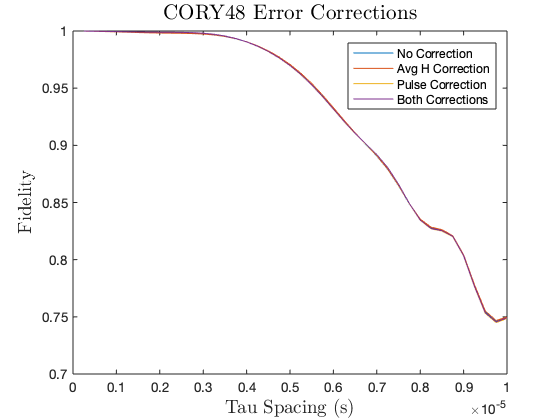

In [36]:
plot(taus(:,1),results(:,1))
hold on
plot(taus(:,1),results_2(:,1))
plot(taus(:,1),results_D(:,1))
plot(taus(:,1),results_D2(:,1))

h=title(strcat(testSequence,' Error Corrections'));
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);
legend('experimental pulse','instantaneous pulse')


legend('No Correction','Avg H Correction','Pulse Correction','Both Corrections')

In [37]:
filename = strcat(testSequence,'_fidelity_tau_multipleErrors.mat')
save(filename,'taus','results','results_2','results_D','results_D2','Delta','coupling','N')

filename =
    'CORY48_fidelity_tau_multipleErrors.mat'


# Autocorrelation Simulation  ($\tau$)

Fidelity vs Autocorrelation (no magnus, no instantaneous pulses)

In [50]:
testSequence = 'AZ48';
% Valid choices are: 'WHH', 'MREV8', 'CORY48', 'CORY24', 
% 'YXX48', 'YXX24', 'YXX24S' (symmetrized YXX-24), 'AZ48'

In [51]:
global Pulses dim

% Potential Test Vars
N = 4;
dim = 2^N ;
Ncyc = 1;

tau = 3e-6;
pulse = 1.5e-6;
Delta = 500;
coupling = 5000;

testVarCount = 40;

maxCoupling = 50000;
%maxCoupling = 5000;

maxTau = 10e-6;
maxDelta = 1000;

In [52]:
taus = zeros(testVarCount,1);

for i=1:testVarCount
    taus(i) = (i/testVarCount)*maxTau;
end


% Generate Coupling Matrices

as = generateCoupling(N);


% Setup Code Normally Run by spinSimNoPlots

% initialize Pauli matrices and transformation operators
z=0.5*sparse([1 0; 0 -1]);x=0.5*sparse( [ 0 1;1 0]); y=1i*0.5*sparse([0 -1;1 0]);
ep=sparse([1 0; 0 0]);
em=sparse([0 0; 0 1]);
id=speye(2);p=sparse([0 1;0 0]);m=sparse([0 0; 1 0]);


% collective spin observables
global X Y

Z=sparse(dim,dim);
X=sparse(dim,dim);
Y=sparse(dim,dim);

for k=1:N
      Z = Z + mykron(speye(2^(k-1)),z,speye(2^(N-k)));
      X = X + mykron(speye(2^(k-1)),x,speye(2^(N-k)));
      Y = Y + mykron(speye(2^(k-1)),y,speye(2^(N-k)));
end

raw_results = zeros(8,40);
raw_results_h2 = zeros(8,40);
results = zeros(40,1);
results_h2 = zeros(40,1);

raw_autocors = zeros(8,40);
autocors = zeros(40,1);

% Simulation

for dipVal=1:length(as)
    dip = as{dipVal};
    for testVal=1:length(taus)
        tau = taus(testVal);
        Tcyc = 6*tau + 4*pulse; % cycle time

        f1 = 1/4/pulse; %Can adjust f1 and w1 by changing 'pulse' variable
        w1 = 2*pi*f1;

        % define system observables and Hamiltonians

        Hdip = getHdip(N, dim, x, y, z, dip);

        %physical Hamiltonian
        Hint = Hdip*coupling + Z*Delta; 

        %experimental unitary operators
        Utau=(expm(-1i*Hint*2*pi*tau));
        UhalfTau = (expm(-1i*Hint*pi*tau));
        Ux = (expm(-1i*2*pi*(Hint+f1*X)*pulse));
        Uy = (expm(-1i*2*pi*(Hint+f1*Y)*pulse));
        Uxbar = (expm(-1i*2*pi*(Hint-f1*X)*pulse));
        Uybar = (expm(-1i*2*pi*(Hint-f1*Y)*pulse));
        
        %delta pulse unitary operators
        UDx = (expm(-1i*2*pi*(f1*X)*pulse));
        UDy = (expm(-1i*2*pi*(f1*Y)*pulse));
        UDxbar = (expm(-1i*2*pi*(-f1*X)*pulse));
        UDybar = (expm(-1i*2*pi*(-f1*Y)*pulse));

        % SIMULATE SPIN DYNAMICS - - - - - - - - - - - -

        % (Choose desired sequence to test)
        if strcmp(testSequence, 'WHH')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau;
            deltaUnitary = Utau*UDxbar*Utau*UDy*Utau*Utau*UDybar*Utau*UDx*Utau;
            Havg = (Delta / 3) * (X + Y + Z); 
            testCyc = 12;
            cycleTime = 4 * pulse + 6 * tau;
            deltaCycleTime = 6 * tau;
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'MREV8')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uybar*Utau*Uxbar*Utau;
            Havg = (Delta / 3) * (X + Z) ;
            testCyc = 6;
            cycleTime = 8 * pulse + 12 * tau;
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'CORY48') % Not currently functional
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 72 * tau + 48 * pulse;

        elseif strcmp(testSequence, 'CORY24')
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;

        elseif strcmp(testSequence, 'YXX48')
            testUnitary = Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 48*tau + 48*pulse;

        elseif strcmp(testSequence, 'YXX24')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 24*tau + 24*pulse;

        elseif strcmp(testSequence, 'YXX24S')
            testUnitary = Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 48*tau + 48*pulse;

        elseif strcmp(testSequence, 'AZ48')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Ux*Utau*Uy*Utau*Uy*Utau*Uxbar;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 48*tau + 48*pulse;

        end
        
        
        
% CALCULATE AVERAGE HAMILTONIAN TERMS

        sequence = getSequence(testSequence);
        Pulses = sequence.Pulses;
        Taus = tau * sequence.Taus;
        tCyc = sum(Taus);
        
        toggledHsys = {};
        for p = 0:length(Pulses)
            toggledHsys{p+1} = getURF(p)'*Hint*getURF(p);
        end
        

% SPIN SIMULATION - - - - - - - - -

        UcumExp = testUnitary;  % experimental
        UcumH0 = U0;            % target (H0 for spectroscopic, id for time-suspension)
        
        % for autocorrelations
        rhoX = X;
        rhoY = Y;
        rhoZ = Z;
        

        for cycleCount=1:Ncyc
            fidelity0 = zeros(Ncyc, 1);
            cAvg = zeros(Ncyc,1);

            % Evolve density states for autocorrelation
            rhoX = testUnitary*rhoX*testUnitary';
            rhoY = testUnitary*rhoY*testUnitary';
            rhoZ = testUnitary*rhoZ*testUnitary';
            
            % Calculate autocorrelations
            cXX = trace(rhoX*X)/dim;
            cYY = trace(rhoY*Y)/dim;
            cZZ = trace(rhoZ*Z)/dim;
            cAvg(cycleCount) = real((cXX*cYY*cZZ)^(1/3));
            
            % fidelity metric for unitary operators
            fidelity0(cycleCount) = metric(UcumExp, UcumH0, N); %exp compared to order 0
            
            % update unitaries
            UcumExp = UcumExp * testUnitary;
            UcumH0 = UcumH0 * U0;
                                    
        end      
        
        raw_results(dipVal,testVal)=fidelity0(Ncyc);
        raw_autocors(dipVal,testVal) = cAvg(Ncyc);
        
    end
end

for d=1:testVarCount
    for aa=1:8
        results(d) = results(d)+(1/8)*raw_results(aa,d);
        autocors(d) = autocors(d) + (1/8)*raw_autocors(aa,d);
    end
end
'done'

ans =
    'done'


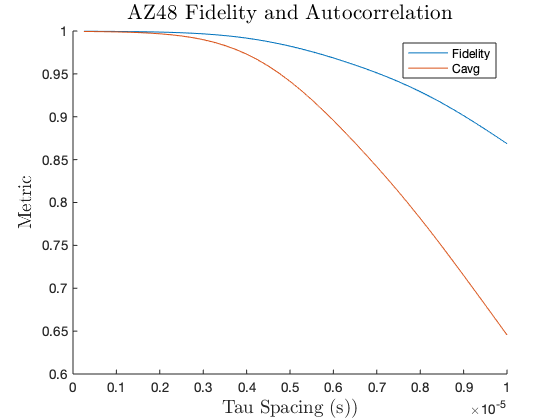

In [53]:
hold on
plot(taus(:,1),results(:,1))
plot(taus(:,1),autocors(:,1))

h=title(strcat(testSequence, ' Fidelity and Autocorrelation'));
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s))');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Metric');
set(h,'interpreter','latex','fontsize',14);
legend('Experimental Pulse','Instantaneous Pulse')

legend('Fidelity','Cavg')

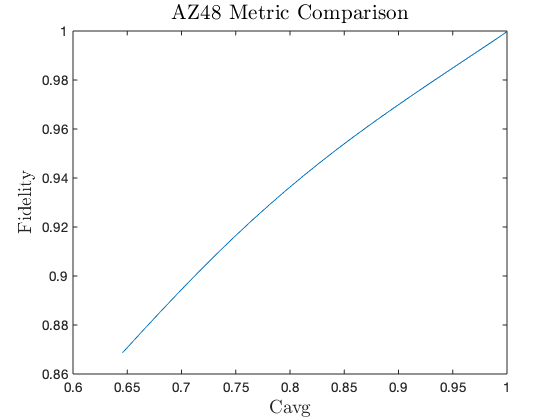

In [54]:
plot(autocors(:,1),results(:,1))

h=title(strcat(testSequence, ' Metric Comparison'));
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Cavg');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

In [55]:
filename = strcat(testSequence,' fidelity_and_Cavg_',date,'.m')
save(filename,'results','autocors','taus','Delta','coupling','N')
'saved'

filename =
    'AZ48 fidelity_and_Cavg_13-Apr-2021.m'
ans =
    'saved'


# Autocorrelation Simulation  (coupling)

In [26]:
testSequence = 'AZ48';
% Valid choices are: 'WHH', 'MREV8', 'CORY48', 'CORY24', 
% 'YXX48', 'YXX24', 'YXX24S' (symmetrized YXX-24), 'AZ48'

In [27]:
global Pulses dim

% Potential Test Vars
N = 4;
dim = 2^N ;
Ncyc = 1;

tau = 3e-6;
pulse = 1.5e-6;
Delta = 500;
coupling = 5000;

testVarCount = 40;

%maxCoupling = 50000;
maxCoupling = 5000;

maxTau = 10e-6;
maxDelta = 1000;

In [28]:
couplings = zeros(testVarCount,1);

for i=1:testVarCount
    couplings(i) = (i/testVarCount)*maxCoupling;
end


% Generate Coupling Matrices

as = generateCoupling(N);


% Setup Code Normally Run by spinSimNoPlots

% initialize Pauli matrices and transformation operators
z=0.5*sparse([1 0; 0 -1]);x=0.5*sparse( [ 0 1;1 0]); y=1i*0.5*sparse([0 -1;1 0]);
ep=sparse([1 0; 0 0]);
em=sparse([0 0; 0 1]);
id=speye(2);p=sparse([0 1;0 0]);m=sparse([0 0; 1 0]);


% collective spin observables
global X Y

Z=sparse(dim,dim);
X=sparse(dim,dim);
Y=sparse(dim,dim);

for k=1:N
      Z = Z + mykron(speye(2^(k-1)),z,speye(2^(N-k)));
      X = X + mykron(speye(2^(k-1)),x,speye(2^(N-k)));
      Y = Y + mykron(speye(2^(k-1)),y,speye(2^(N-k)));
end

raw_results = zeros(8,40);
raw_results_h2 = zeros(8,40);
results = zeros(40,1);
results_h2 = zeros(40,1);

raw_autocors = zeros(8,40);
autocors = zeros(40,1);

% Simulation

for dipVal=1:length(as)
    dip = as{dipVal};
    for testVal=1:length(taus)
        coupling = couplings(testVal);
        Tcyc = 6*tau + 4*pulse; % cycle time

        f1 = 1/4/pulse; %Can adjust f1 and w1 by changing 'pulse' variable
        w1 = 2*pi*f1;

        % define system observables and Hamiltonians

        Hdip = getHdip(N, dim, x, y, z, dip);

        %physical Hamiltonian
        Hint = Hdip*coupling + Z*Delta; 

        %experimental unitary operators
        Utau=(expm(-1i*Hint*2*pi*tau));
        UhalfTau = (expm(-1i*Hint*pi*tau));
        Ux = (expm(-1i*2*pi*(Hint+f1*X)*pulse));
        Uy = (expm(-1i*2*pi*(Hint+f1*Y)*pulse));
        Uxbar = (expm(-1i*2*pi*(Hint-f1*X)*pulse));
        Uybar = (expm(-1i*2*pi*(Hint-f1*Y)*pulse));
        
        %delta pulse unitary operators
        UDx = (expm(-1i*2*pi*(f1*X)*pulse));
        UDy = (expm(-1i*2*pi*(f1*Y)*pulse));
        UDxbar = (expm(-1i*2*pi*(-f1*X)*pulse));
        UDybar = (expm(-1i*2*pi*(-f1*Y)*pulse));

        % SIMULATE SPIN DYNAMICS - - - - - - - - - - - -

        % (Choose desired sequence to test)
        if strcmp(testSequence, 'WHH')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau;
            deltaUnitary = Utau*UDxbar*Utau*UDy*Utau*Utau*UDybar*Utau*UDx*Utau;
            Havg = (Delta / 3) * (X + Y + Z); 
            testCyc = 12;
            cycleTime = 4 * pulse + 6 * tau;
            deltaCycleTime = 6 * tau;
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'MREV8')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uybar*Utau*Uxbar*Utau;
            Havg = (Delta / 3) * (X + Z) ;
            testCyc = 6;
            cycleTime = 8 * pulse + 12 * tau;
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'CORY48') % Not currently functional
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 72 * tau + 48 * pulse;

        elseif strcmp(testSequence, 'CORY24')
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;

        elseif strcmp(testSequence, 'YXX48')
            testUnitary = Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 48*tau + 48*pulse;

        elseif strcmp(testSequence, 'YXX24')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 24*tau + 24*pulse;

        elseif strcmp(testSequence, 'YXX24S')
            testUnitary = Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 48*tau + 48*pulse;

        elseif strcmp(testSequence, 'AZ48')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Ux*Utau*Uy*Utau*Uy*Utau*Uxbar;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 48*tau + 48*pulse;

        end
        
        
        
% CALCULATE AVERAGE HAMILTONIAN TERMS

        sequence = getSequence(testSequence);
        Pulses = sequence.Pulses;
        Taus = tau * sequence.Taus;
        tCyc = sum(Taus);
        
        toggledHsys = {};
        for p = 0:length(Pulses)
            toggledHsys{p+1} = getURF(p)'*Hint*getURF(p);
        end
        

% SPIN SIMULATION - - - - - - - - -

        UcumExp = testUnitary;  % experimental
        UcumH0 = U0;            % target (H0 for spectroscopic, id for time-suspension)
        
        % for autocorrelations
        rhoX = X;
        rhoY = Y;
        rhoZ = Z;
        

        for cycleCount=1:Ncyc
            fidelity0 = zeros(Ncyc, 1);
            cAvg = zeros(Ncyc,1);

            % Evolve density states for autocorrelation
            rhoX = testUnitary*rhoX*testUnitary';
            rhoY = testUnitary*rhoY*testUnitary';
            rhoZ = testUnitary*rhoZ*testUnitary';
            
            % Calculate autocorrelations
            cXX = trace(rhoX*X)/dim;
            cYY = trace(rhoY*Y)/dim;
            cZZ = trace(rhoZ*Z)/dim;
            cAvg(cycleCount) = real((cXX*cYY*cZZ)^(1/3));
            
            % fidelity metric for unitary operators
            fidelity0(cycleCount) = metric(UcumExp, UcumH0, N); %exp compared to order 0
            
            % update unitaries
            UcumExp = UcumExp * testUnitary;
            UcumH0 = UcumH0 * U0;
                                    
        end      
        
        raw_results(dipVal,testVal)=fidelity0(Ncyc);
        raw_autocors(dipVal,testVal) = cAvg(Ncyc);
        
    end
end

for d=1:testVarCount
    for aa=1:8
        results(d) = results(d)+(1/8)*raw_results(aa,d);
        autocors(d) = autocors(d) + (1/8)*raw_autocors(aa,d);
    end
end
'done'

ans =
    'done'


In [29]:
filename = strcat(testSequence,'_coupling_fidelity_and_Cavg_',date,'.m')
save(filename,'results','autocors','tau','Delta','couplings','N')
'saved'

filename =
    'AZ48_coupling_fidelity_and_Cavg_17-Apr-2021.m'
ans =
    'saved'


# $\tau$ Simulation with Corrected Pulse Magnus (test)

In [16]:
testSequence = 'CORY48';
% Valid choices are: 'WHH', 'MREV8', 'CORY48', 'CORY24', 
% 'YXX48', 'YXX24', 'YXX24S' (symmetrized YXX-24), 'AZ48'

In [17]:
global Pulses dim

% Potential Test Vars
N = 4;
dim = 2^N ;
Ncyc = 1;

tau = 3e-6;
pulse = 1.5e-6;
Delta = 500;
coupling = 5000;

testVarCount = 40;

%maxCoupling = 50000;
maxCoupling = 5000;

maxTau = 10e-6;
maxDelta = 1000;

In [18]:
taus = zeros(testVarCount);

for i=1:testVarCount
    taus(i) = (i/testVarCount)*maxTau;
end


%% Generate Coupling Matrices

as = generateCoupling(N);


%% Setup Code Normally Run by spinSimNoPlots

% initialize Pauli matrices and transformation operators
z=0.5*sparse([1 0; 0 -1]);x=0.5*sparse( [ 0 1;1 0]); y=1i*0.5*sparse([0 -1;1 0]);
ep=sparse([1 0; 0 0]);
em=sparse([0 0; 0 1]);
id=speye(2);p=sparse([0 1;0 0]);m=sparse([0 0; 1 0]);


% collective spin observables
global X Y

Z=sparse(dim,dim);
X=sparse(dim,dim);
Y=sparse(dim,dim);

for k=1:N
      Z = Z + mykron(speye(2^(k-1)),z,speye(2^(N-k)));
      X = X + mykron(speye(2^(k-1)),x,speye(2^(N-k)));
      Y = Y + mykron(speye(2^(k-1)),y,speye(2^(N-k)));
end

raw_results = zeros(8,40);
raw_results_h2 = zeros(8,40);
results = zeros(40,1);
results_h2 = zeros(40,1);

%% Simulation

for dipVal=1:length(as)
    dip = as{dipVal};
    for testVal=1:length(taus)
        tau = taus(testVal);
        Tcyc = 6*tau + 4*pulse; % cycle time

        f1 = 1/4/pulse; %Can adjust f1 and w1 by changing 'pulse' variable
        w1 = 2*pi*f1;

        % define system observables and Hamiltonians

        Hdip = getHdip(N, dim, x, y, z, dip);

        %physical Hamiltonian
        Hint = Hdip*coupling + Z*Delta; 

        %Lowest order WAHUHA and MREV hamiltonian
        tc = 6*tau + 4*pulse;

        tcM = 12*tau + 8*pulse;

        % Define Unitaries

        %experimental unitary operators
        Utau=(expm(-1i*Hint*2*pi*tau));
        UhalfTau = (expm(-1i*Hint*pi*tau));
        Ux = (expm(-1i*2*pi*(Hint+f1*X)*pulse));
        Uy = (expm(-1i*2*pi*(Hint+f1*Y)*pulse));
        Uxbar = (expm(-1i*2*pi*(Hint-f1*X)*pulse));
        Uybar = (expm(-1i*2*pi*(Hint-f1*Y)*pulse));
        
        %delta pulse unitary operators
        UDx = (expm(-1i*2*pi*(f1*X)*pulse));
        UDy = (expm(-1i*2*pi*(f1*Y)*pulse));
        UDxbar = (expm(-1i*2*pi*(-f1*X)*pulse));
        UDybar = (expm(-1i*2*pi*(-f1*Y)*pulse));

        % SIMULATE SPIN DYNAMICS - - - - - - - - - - - -

        % (Choose desired sequence to test)
        if strcmp(testSequence, 'WHH')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau;
            deltaUnitary = Utau*UDxbar*Utau*UDy*Utau*Utau*UDybar*Utau*UDx*Utau;
            Havg = (Delta / 3) * (X + Y + Z); 
            testCyc = 12;
            
            cycleTime = 4 * pulse + 6 * tau;
            deltaCycleTime = 6 * tau;
            
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'MREV8')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uybar*Utau*Uxbar*Utau;
            Havg = (Delta / 3) * (X + Z) ;
            testCyc = 6;
            cycleTime = 8 * pulse + 12 * tau;
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'CORY48') % Not currently functional
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 72 * tau + 48 * pulse;

        elseif strcmp(testSequence, 'CORY24')
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;

        elseif strcmp(testSequence, 'YXX48')
            testUnitary = Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 49*tau + 48*pulse;

        elseif strcmp(testSequence, 'YXX24')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 25*tau + 24*pulse;

        elseif strcmp(testSequence, 'YXX24S')
            testUnitary = Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 49*tau + 48*pulse;

        elseif strcmp(testSequence, 'AZ48')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Ux*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 49*tau + 48*pulse;

        end
        
        
        
% CALCULATE AVERAGE HAMILTONIAN TERMS

        sequence = getSequence(testSequence);
        Pulses = sequence.Pulses;
        Taus = tau * sequence.Taus;
        
        %pulse length corrections to Taus - - - - - - 
        Taus(1) = Taus(1) + pulse/2;
    
        for ttt = 2:(length(Taus)-1)
            Taus(ttt) = Taus(ttt) + pulse;
        end
    
        Taus(length(Taus)) = Taus(length(Taus)) + pulse/2;
    
    %end pulse-length corrections to Taus - - - - 
        
        
        tCyc = sum(Taus);
        
        toggledHsys = {};
        for p = 0:length(Pulses)
            toggledHsys{p+1} = getURF(p)'*Hint*getURF(p);
        end
        
        %Calculate 0th order Magnus term
        H0 = zeros(dim,dim);
        for k=0:length(Pulses)
            URF = getURF(k);
            Htilde = (URF')*Hint*URF;
            Taus(k+1);
            H0 = H0 + (Taus(k+1))*Htilde;
        end

        H0 = (1/tCyc)*H0;


        %Calculate 1st order Magnus term
        H1 = zeros(dim,dim);
        for k=1:length(Pulses)
            for j=0:k-1
                Hk = toggledHsys{k+1};
                Hj = toggledHsys{j+1};
                H1 = H1 + comm(Hk,Hj)*Taus(k+1)*Taus(j+1);
            end
        end

        H1 = (1/(2*1i*tCyc))*H1;

        %Calculate 2nd order Magnus term
        H2 = zeros(dim,dim);
        for l=0:length(Pulses)
            for k=0:l
                for j=0:k
                    Hl = toggledHsys{l+1};
                    Hk = toggledHsys{k+1};
                    Hj = toggledHsys{j+1};

                    Hterm = comm(Hl,comm(Hk,Hj))+comm(comm(Hl,Hk),Hj);
                    H2 = H2 + Hterm*Taus(l+1)*Taus(k+1)*Taus(j+1);
                end
            end
        end

        H2 = (-1/(6*tCyc))*H2;       
        
        Havg = H0 + H1 + H2;
        
        Uavg = expm(-1i*Havg*2*pi*cycleTime);
        

% SPIN SIMULATION - - - - - - - - -

        UcumExp = testUnitary;  % experimental
        %UcumD = deltaUnitary;    %infinitesimal (delta) pulses
        
        UcumH0 = U0;            % target (H0 for spectroscopic, id for time-suspension)
        UcumHavg = Uavg;        % first 3 terms

        for cycleCount=1:Ncyc
            fidelity0 = zeros(Ncyc, 1);
            fidelity3 = zeros(Ncyc, 1);
            %fidelityD = zeros(Ncyc, 1);

            %Unitary Evolution

            simTime = 0;

            % fidelity metric for unitary operators
            fidelity0(cycleCount) = metric(UcumExp, UcumH0, N); %exp compared to order 0
            fidelity3(cycleCount) = metric(UcumExp, UcumHavg, N); %exp compared to orders 0-2
            
            %fidelityD(cycleCount) = metric(UcumD, UcumH0, N); %deltapulse compared to order 0
            
            UcumExp = UcumExp * testUnitary;
            UcumH0 = UcumH0 * U0;
            UcumHavg = UcumHavg * Uavg;
            %UcumD = UcumD * deltaUnitary;
            
        end      
        
        raw_results(dipVal,testVal)=fidelity0(Ncyc);
        raw_results_h2(dipVal,testVal)=fidelity3(Ncyc);
        %raw_results_h2(dipVal,testVal) = fidelityD(Ncyc);
        
    end
end

for d=1:40
    for aa=1:8
        results(d) = results(d)+(1/8)*raw_results(aa,d);
        results_h2(d) = results_h2(d)+(1/8)*raw_results_h2(aa,d);
    end
end
'done'

ans =
    'done'


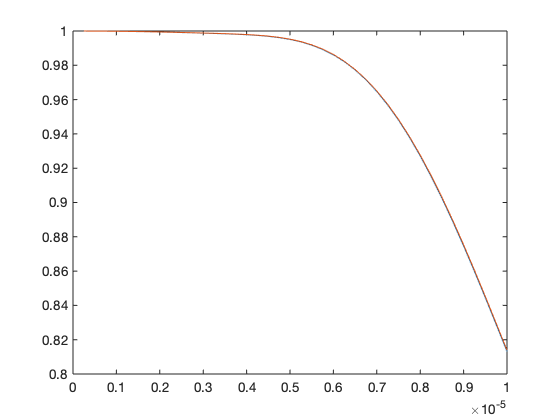

In [19]:
plot(taus(:,1),results(:,1))
hold on
plot(taus(:,1),results_h2(:,1))

In [20]:
filename = strcat(testSequence,'_PCMagnus_fidelity_',date,'.m')
save(filename,'results','results_h2','taus','coupling','delta','N')

filename =
    'CORY48_PCMagnus_fidelity_18-Apr-2021.m'


Error using save
Variable 'delta' not found.
